# Colorectal histology - Final Project
Author: Gabriel TRUONG

This project aims to apply a model development cycle by iterativaly improve the model through: 
1. **Architecture** (model, data, etc.)
2. **Training of the model**
3. **Diagnose** (evalution metrics, bias, variance , errors)

The dataset comes from a study conducted by Kather JN, Weis CA, Bianconi F, Melchers SM, Schad LR, Gaiser T, Marx A, Zollner F published in the Scientific Reports (in press). The name of the article is [*Multi-class texture analysis in colorectal cancer histology (2016)*](https://zenodo.org/record/53169#.Y58H9tLMKvX).

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Sequential
from tensorflow_datasets.image_classification import colorectal_histology
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score

import datetime
SEED = 42

In [2]:
def plot_accuracy_loss(history):
    fig,ax = plt.subplots(1,2,figsize=(10,8))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title("model accuracy")
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'test'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'test'], loc='upper left')
    
    fig.show()

## Data Collection

In [3]:
(train_ds,train_label),(val_ds, val_label)= tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split=["train[:80%]", "train[80%:]"],
    batch_size=-1,
    shuffle_files=True,
    as_supervised=True,
))

print(f"The data is of type {type(train_ds)} and each image has a {train_ds.shape} shape")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incomplete6S11QW/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
The data is of type <class 'numpy.ndarray'> and each image has a (4000, 150, 150, 3) shape


## Exploratory Data Analysis <a name="EDA"></a>

In [5]:
class_names = colorectal_histology._CLASS_NAMES
class_names

('tumor',
 'stroma',
 'complex',
 'lympho',
 'debris',
 'mucosa',
 'adipose',
 'empty')

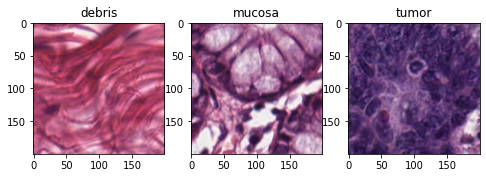

In [6]:
fig, ax = plt.subplots(1,3,figsize=(8,8))
size=(200,200)

img = [Image.fromarray(train_ds[i], 'RGB').resize(size) for i in range(4)]

ax[0].imshow(img[0],cmap = 'gray')
ax[0].set_title(class_names[train_label[0]])
ax[1].imshow(img[1],cmap = 'gray')
ax[1].set_title(class_names[train_label[1]])
ax[2].imshow(img[3],cmap = 'gray')
ax[2].set_title(class_names[train_label[3]])
plt.show()

Text(0.5, 1.0, 'Number of occurences of a val label')

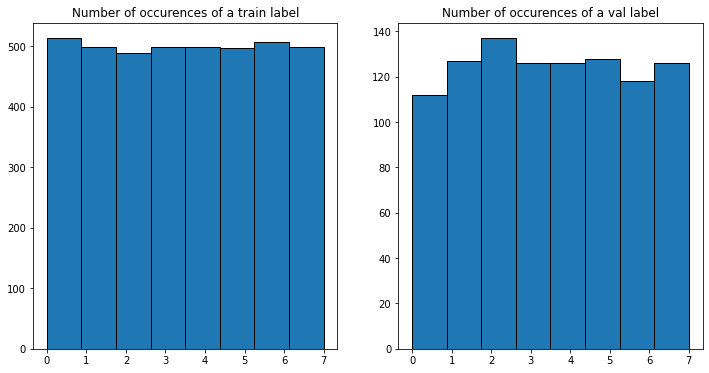

In [7]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(train_label, bins=len(np.unique(train_label)), edgecolor="black")
ax1.set_title("Number of occurences of a train label")

ax2.hist(val_label, bins=len(np.unique(val_label)), edgecolor="black")
ax2.set_title("Number of occurences of a val label")

We can see that the training set is quite balanced. The validation set is not as balanced but it enables to see how the model perform on a slightly different distribution.

In [7]:
tf.keras.utils.set_random_seed(SEED)

**`Launch tensorboard to monitor the training`**

In [9]:
%tensorboard --logdir logs/fit


UsageError: Line magic function `%tensorboard` not found.


## Model Development

### Baseline model

This model is simple Artificial Neural Network. The architecture comes from a lab on the fashion MNIST dataset. Since we are dealing with images, we add a flatten layer to suit the architecture. Without this preprocessing layer, not all the layers will be fully connected to the input.

In [10]:
logs = {}

baseline_model = Sequential([
    layers.Flatten(input_shape=[150, 150,3]),
    layers.Dense(300,activation="relu"),
    layers.Dense(100,activation="relu"),
    layers.Dense(8,activation="softmax")
])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 300)               20250300  
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
Total params: 20,281,208
Trainable params: 20,281,208
Non-trainable params: 0
_________________________________________________________________


In [11]:
baseline_model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")

For this baseline model, we only add a tensorboard callback to monitor the training.

In [12]:
log_dir = "logs/colorectal_project_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
baseline_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [13]:
logs["Baseline"] = baseline_model.fit(train_ds,train_label,
                            epochs=30,callbacks=baseline_cb,
                            validation_data=(val_ds,val_label))

Epoch 1/30
125/125 [==============================] - 9s 51ms/step - loss: 4135.1069 - accuracy: 0.2320 - val_loss: 2630.0027 - val_accuracy: 0.3190
Epoch 2/30
125/125 [==============================] - 7s 56ms/step - loss: 1656.9583 - accuracy: 0.3130 - val_loss: 757.7240 - val_accuracy: 0.3230
Epoch 3/30
125/125 [==============================] - 5s 42ms/step - loss: 582.6296 - accuracy: 0.3700 - val_loss: 644.4039 - val_accuracy: 0.2820
Epoch 4/30
125/125 [==============================] - 5s 39ms/step - loss: 342.5438 - accuracy: 0.4033 - val_loss: 94.2734 - val_accuracy: 0.4630
Epoch 5/30
125/125 [==============================] - 5s 37ms/step - loss: 167.9234 - accuracy: 0.4347 - val_loss: 202.0399 - val_accuracy: 0.3880
Epoch 6/30
125/125 [==============================] - 5s 37ms/step - loss: 107.5811 - accuracy: 0.4997 - val_loss: 76.9840 - val_accuracy: 0.5110
Epoch 7/30
125/125 [==============================] - 5s 37ms/step - loss: 96.7206 - accuracy: 0.5063 - val_loss: 69.

In [14]:
print(baseline_model.evaluate(val_ds,val_label))
baseline_predictions=baseline_model.predict(val_ds)

32/32 [==============================] - 0s 9ms/step - loss: 1.7571 - accuracy: 0.2400
[1.7570881843566895, 0.23999999463558197]
32/32 [==============================] - 0s 8ms/step


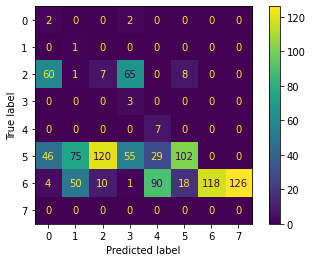

In [15]:
baseline_cm=confusion_matrix(np.argmax(baseline_predictions,axis=1),val_label)
ConfusionMatrixDisplay(baseline_cm).plot()

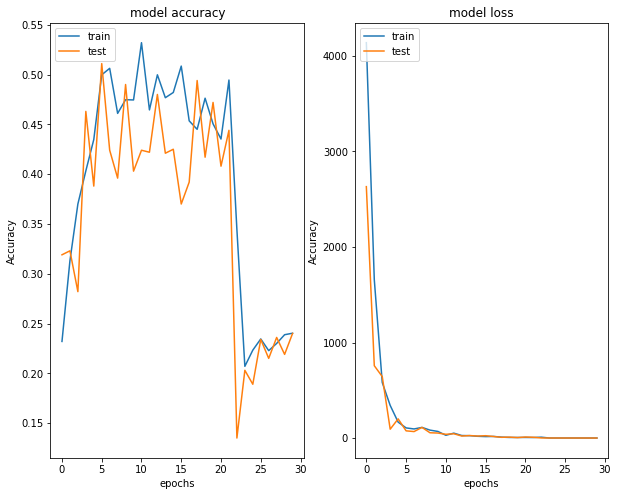

In [18]:
plot_accuracy_loss(logs['Baseline'])

In [16]:
print(f"accuracy of the baseline model on training set: {accuracy_score(train_label,np.argmax(baseline_model.predict(train_ds),axis=1))}")
print(f"accuracy of the baseline model on validation set: {accuracy_score(val_label,np.argmax(baseline_predictions,axis=1))}")

125/125 [==============================] - 1s 8ms/step
accuracy of the baseline model on training set: 0.2555
accuracy of the baseline model on validation set: 0.24


For our baseline model, we get a low accuracy on both the training and the validation set. 
Also we can see with the confusion matrix that the model only predict on few labels and miss many of them. We need to add complexity so that the model also predicts on the other labels. Also we need to be careful of overfitting.

### Convolutional Neural Network

With this model, we want to add complexity by adding more suitable layers such as Convolution2D and MaxPool2D. This model 

In [19]:
basic_cnn = Sequential([
            layers.Convolution2D(64, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])
basic_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 20)        11540     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 20)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 12)        2172      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 12)      

In [20]:
log_dir = "logs/colorectal_project_CNN" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
basic_CNN_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [21]:
basic_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_cnn=basic_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=basic_CNN_cb)

Epoch 1/30
125/125 [==============================] - 15s 30ms/step - loss: 2.4179 - accuracy: 0.2765 - val_loss: 1.6836 - val_accuracy: 0.3270
Epoch 2/30
125/125 [==============================] - 4s 29ms/step - loss: 1.4705 - accuracy: 0.4185 - val_loss: 1.2440 - val_accuracy: 0.5290
Epoch 3/30
125/125 [==============================] - 3s 27ms/step - loss: 1.3002 - accuracy: 0.4875 - val_loss: 1.5615 - val_accuracy: 0.3410
Epoch 4/30
125/125 [==============================] - 3s 27ms/step - loss: 1.3100 - accuracy: 0.4642 - val_loss: 1.2857 - val_accuracy: 0.4720
Epoch 5/30
125/125 [==============================] - 4s 28ms/step - loss: 1.0611 - accuracy: 0.5742 - val_loss: 1.0850 - val_accuracy: 0.5240
Epoch 6/30
125/125 [==============================] - 4s 28ms/step - loss: 0.9675 - accuracy: 0.6162 - val_loss: 0.9381 - val_accuracy: 0.5910
Epoch 7/30
125/125 [==============================] - 4s 30ms/step - loss: 0.8532 - accuracy: 0.6532 - val_loss: 0.9596 - val_accuracy: 0.600

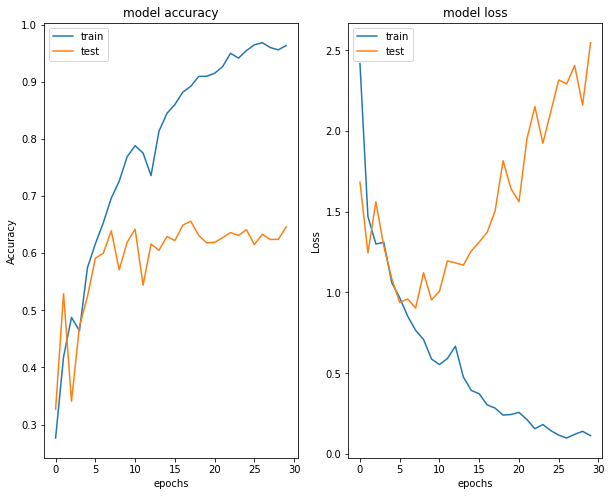

In [24]:
plot_accuracy_loss(history_cnn)

On the graph shown ,we can clearly see at 10th epochs, the validation loss stopped decreasing while the training loss kept decreasing. Underfitting is quite obvious here, we will confirm this intuition with confusion matrix.

In [25]:
cnn_prediction=basic_cnn.predict(val_ds)

32/32 [==============================] - 0s 10ms/step


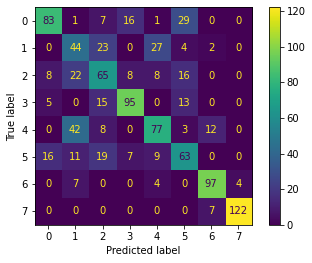

In [26]:
moredepth_cm=confusion_matrix(np.argmax(cnn_prediction,axis=1),val_label)
ConfusionMatrixDisplay(moredepth_cm).plot()

From the plots, we can clearly see that the model performs very well on the training set but not on the validation set. We reached a good generalization and now to improve the performance on the validation set we need to reduce the overfitting. To do so, we could either use a Dropout layer or add data augmentation to add data. 
We will try the 2nd option and see if it works.

In [27]:
print(f"accuracy of the first CNN model on training set: {accuracy_score(train_label,np.argmax(basic_cnn.predict(train_ds),axis=1))}")
print(f"accuracy of the first CNN model on validation set: {accuracy_score(val_label,np.argmax(cnn_prediction,axis=1))}")

125/125 [==============================] - 1s 9ms/step
accuracy of the first CNN model on training set: 0.982
accuracy of the first CNN model on validation set: 0.646


### Reduce overfitting

#### Data Augmentation

In this part we will add Data Augmentation layers to add different point of view for the model. We expect the model to be less overfitted since it will train on more data. 

In [11]:
augmented_cnn = Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            layers.Convolution2D(64, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='elu', units=128),
            layers.Dense(activation='softmax', units=8),
])


In [12]:
log_dir = "logs/colorectal_project_augmented" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
augmented_CNN_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [13]:
augmented_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_augmented=augmented_cnn.fit(train_ds,train_label,
                            epochs=30,
                            validation_data=(val_ds,val_label),callbacks=augmented_CNN_cb)

Epoch 1/30
125/125 [==============================] - 7s 49ms/step - loss: 2.5649 - accuracy: 0.2657 - val_loss: 1.5388 - val_accuracy: 0.2930
Epoch 2/30
125/125 [==============================] - 6s 47ms/step - loss: 1.4600 - accuracy: 0.4395 - val_loss: 1.5159 - val_accuracy: 0.3240
Epoch 3/30
125/125 [==============================] - 6s 47ms/step - loss: 1.2338 - accuracy: 0.5060 - val_loss: 1.0241 - val_accuracy: 0.5780
Epoch 4/30
125/125 [==============================] - 6s 47ms/step - loss: 1.0162 - accuracy: 0.6152 - val_loss: 0.8569 - val_accuracy: 0.6710
Epoch 5/30
125/125 [==============================] - 6s 47ms/step - loss: 0.9364 - accuracy: 0.6392 - val_loss: 0.8705 - val_accuracy: 0.6570
Epoch 6/30
125/125 [==============================] - 6s 47ms/step - loss: 1.0012 - accuracy: 0.5993 - val_loss: 0.9435 - val_accuracy: 0.6540
Epoch 7/30
125/125 [==============================] - 6s 47ms/step - loss: 0.8769 - accuracy: 0.6628 - val_loss: 0.8549 - val_accuracy: 0.6680

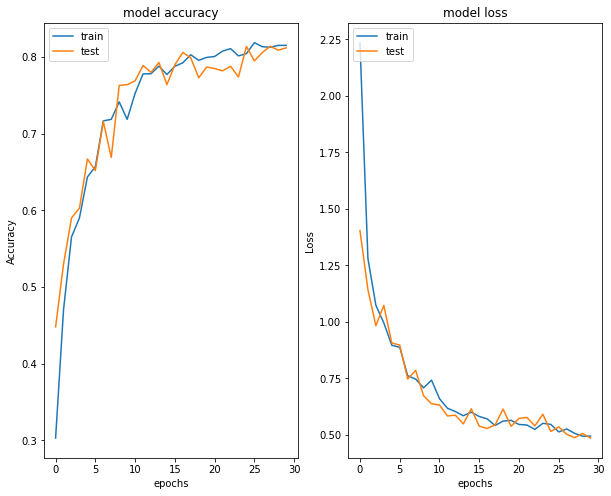

In [31]:
plot_accuracy_loss(history_augmented)

On the graph shown ,we can clearly see at 10th epochs, the validation loss stopped decreasing while the training loss kept decreasing. Underfitting is quite obvious here, we will confirm this intuition with confusion matrix.

In [32]:
augmented_prediction=augmented_cnn.predict(val_ds)

32/32 [==============================] - 0s 10ms/step


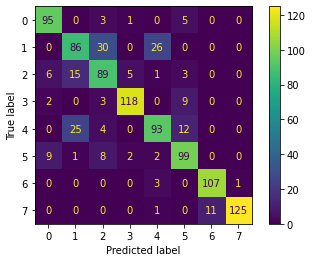

In [34]:
augmented_cm=confusion_matrix(np.argmax(augmented_prediction,axis=1),val_label)
ConfusionMatrixDisplay(augmented_cm).plot()

In [35]:
print(f"accuracy of the augmented CNN model on training set: {accuracy_score(train_label,np.argmax(augmented_cnn.predict(train_ds),axis=1))}")
print(f"accuracy of the augmented CNN model on validation set: {accuracy_score(val_label,np.argmax(augmented_prediction,axis=1))}")

125/125 [==============================] - 1s 9ms/step
accuracy of the augmented CNN model on training set: 0.8475
accuracy of the augmented CNN model on validation set: 0.812


#### Add complexity and early stoppings

In the previous step, we use data augmentation to reduce overfitting and it worked very well. Now we will add complexity and a early-stopping callback to prevent overfitting again. Also it sould save us some computational time. If this step doesn't work, we will stick to the already very accurate model.

In [4]:
wider_cnn = Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),
            layers.Convolution2D(64, (3 ,3), activation='relu',input_shape=(150,150,3)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(20, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(12, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Convolution2D(8, (3, 3), activation='relu'),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(activation='relu', units=128),
            layers.Dense(activation='softmax', units=8),
])


In [5]:
log_dir = "logs/colorectal_project_wider" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
wider_CNN_cb = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True),
tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]


In [6]:
wider_cnn.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
history_wider=wider_cnn.fit(train_ds,train_label,
                            epochs=60,
                            validation_data=(val_ds,val_label),callbacks=wider_CNN_cb)

Epoch 1/60
125/125 [==============================] - 17s 53ms/step - loss: 2.1054 - accuracy: 0.2505 - val_loss: 1.7428 - val_accuracy: 0.3230
Epoch 2/60
125/125 [==============================] - 6s 47ms/step - loss: 1.6221 - accuracy: 0.3528 - val_loss: 1.4768 - val_accuracy: 0.4170
Epoch 3/60
125/125 [==============================] - 6s 48ms/step - loss: 1.4296 - accuracy: 0.4308 - val_loss: 1.2773 - val_accuracy: 0.5090
Epoch 4/60
125/125 [==============================] - 6s 48ms/step - loss: 1.3305 - accuracy: 0.4473 - val_loss: 1.1759 - val_accuracy: 0.5180
Epoch 5/60
125/125 [==============================] - 6s 47ms/step - loss: 1.1759 - accuracy: 0.5170 - val_loss: 1.0392 - val_accuracy: 0.5690
Epoch 6/60
125/125 [==============================] - 6s 49ms/step - loss: 1.1011 - accuracy: 0.5465 - val_loss: 0.9909 - val_accuracy: 0.5770
Epoch 7/60
125/125 [==============================] - 6s 49ms/step - loss: 1.0006 - accuracy: 0.5975 - val_loss: 0.9106 - val_accuracy: 0.623

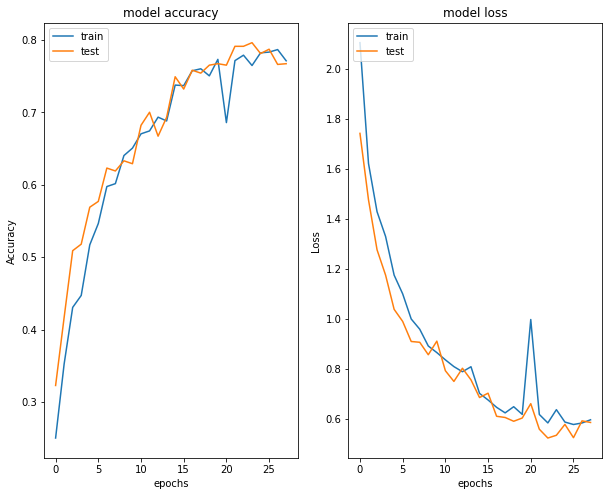

In [14]:
plot_accuracy_loss(history_wider)

In [15]:
wider_prediction=wider_cnn.predict(val_ds)

32/32 [==============================] - 0s 9ms/step


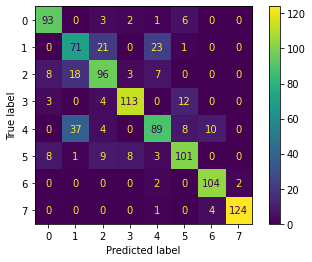

In [16]:
wider_cm=confusion_matrix(np.argmax(wider_prediction,axis=1),val_label)
ConfusionMatrixDisplay(wider_cm).plot()

In [17]:
print(f"accuracy of the early stopped CNN model on training set: {accuracy_score(train_label,np.argmax(wider_cnn.predict(train_ds),axis=1))}")
print(f"accuracy of the early stopped CNN model on validation set: {accuracy_score(val_label,np.argmax(wider_prediction,axis=1))}")

125/125 [==============================] - 1s 8ms/step
accuracy of the early stopped CNN model on training set: 0.8055
accuracy of the early stopped CNN model on validation set: 0.791


### Archive

more_depth_model = Sequential([
    layers.Flatten(input_shape=[150, 150,3]),
    layers.Dense(300,activation="relu"),
    layers.Dense(100,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(8,activation="softmax")
])
more_depth_model.summary()
more_depth_model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),
metrics="accuracy")
For this baseline model, we only add a tensorboard callback to monitor the training.
log_dir = "logs/colorectal_project_depth_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
more_depth_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

logs["more_depth"] = more_depth_model.fit(train_ds,train_label,
                            epochs=10,callbacks=more_depth_cb,
                            validation_data=(val_ds,val_label),batch_size=16)
plot_monitoring(logs['more_depth'])
print(more_depth_model.evaluate(val_ds,val_label))
more_depth_predictions=more_depth_model.predict(val_ds)
moredepth_cm=confusion_matrix(np.argmax(more_depth_predictions,axis=1),val_label)
ConfusionMatrixDisplay(moredepth_cm).plot()